In [ ]:
import os
import random
from collections import Counter
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

#Nama: Lea Audrey
#NIM: 2702261914

# Link Video: https://drive.google.com/file/d/1aY1w3ToEK70Pq8HUh-dEA0NZF_DTxS04/view?usp=sharing

## Read File

In [ ]:
import zipfile
import os
from google.colab import files

def extract_zip(zip_filename, extract_folder, folder_to_extract="A_23"):
    with zipfile.ZipFile(zip_filename, "r") as zip_ref:
        zip_contents = zip_ref.namelist()

        folder_found = [f for f in zip_contents if f.startswith(folder_to_extract)]

        if folder_found:
            zip_ref.extractall(extract_folder, members=folder_found)
            print(f"Folder '{folder_to_extract}' from {zip_filename} has been successfully extracted to {extract_folder}")
        else:
            print(f"Folder '{folder_to_extract}' not found in {zip_filename}")

# Upload files
uploaded = files.upload()
extract_folder = "/content/extracted_data"

# Create extraction folder if it doesn't exist
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

for zip_filename in uploaded.keys():
    extract_zip(zip_filename, extract_folder)

# Data folder path
data_folder = os.path.join(extract_folder, 'A_23')


if os.path.exists(data_folder):
    print(f"Data folder located at: {data_folder}")
else:
    print("The 'A_23' folder was not found after extraction.")

label = {
    'A_23': data_folder
}

Saving A_23.zip to A_23 (1).zip
Folder 'A_23' from A_23 (1).zip has been successfully extracted to /content/extracted_data
Data folder located at: /content/extracted_data/A_23


# Exploratory Data Analysis

### Jumlah Gambar

In [ ]:
def count_images_in_folder(folder_path, image_extensions=[".jpg", ".jpeg", ".png", ".gif", ".bmp"]):
    image_count = 0
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_count += 1
    return image_count
total_images = count_images_in_folder(data_folder)
print(f"Total number of images in the folder: {total_images}")

Total number of images in the folder: 1074


Total gambar pada dataset ini adalah 1074 gambar

### Contoh Gambar

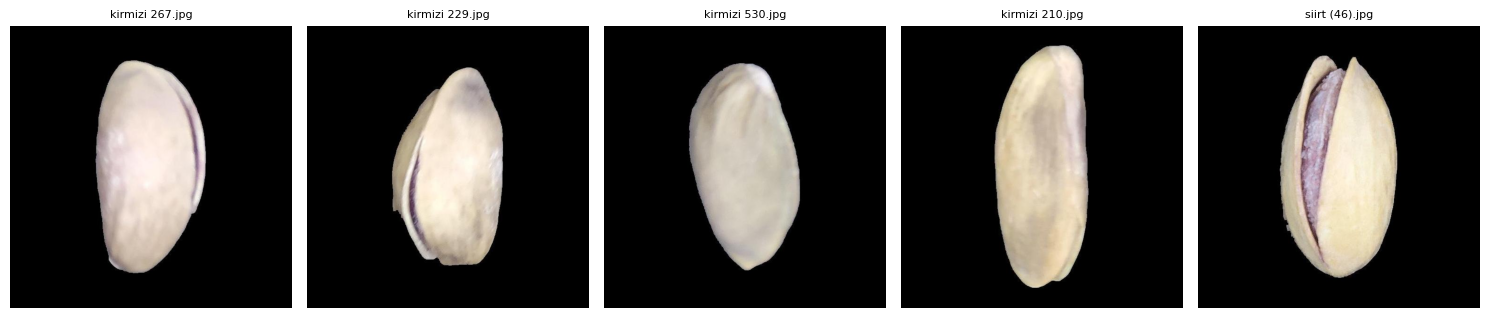

In [ ]:
all_images = [f for f in os.listdir(data_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

n_samples = 5
n_samples = min(n_samples, len(all_images))

plt.figure(figsize=(15, 10))
i = 1

# Random
random_images = random.sample(all_images, n_samples)

# Display
for img_name in random_images:
    img_path = os.path.join(data_folder, img_name)
    try:
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, n_samples, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_name, fontsize=8)
        i += 1
    except Exception as e:
        print(f"Error opening image {img_path}: {e}")

plt.tight_layout()
plt.show()

### Variabilitas --> Lighting

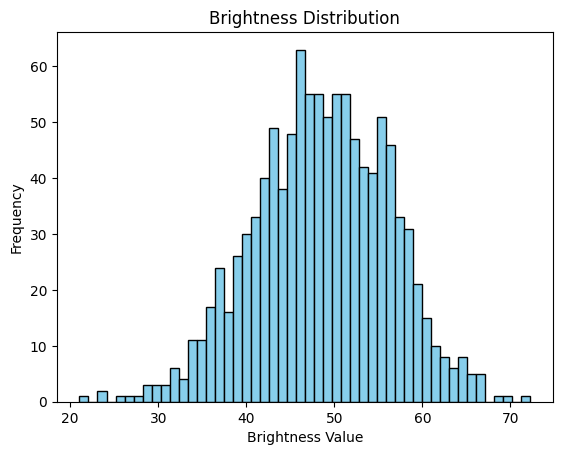

Mean Brightness: 48.56037723463687
Standard Deviation: 7.652639995629842


In [ ]:
# Variability -> Lighting
def analyze_lighting_variability(folder_path):
    brightness_values = [np.mean(cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2GRAY))
                         for root, _, files in os.walk(folder_path)
                         for file in files if file.lower().endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))]

    mean_brightness, std_brightness = np.mean(brightness_values), np.std(brightness_values)

    plt.hist(brightness_values, bins=50, color='skyblue', edgecolor='black')
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness Value')
    plt.ylabel('Frequency')
    plt.show()

    return mean_brightness, std_brightness

if os.path.exists(data_folder):
    mean_brightness, std_brightness = analyze_lighting_variability(data_folder)
    print(f"Mean Brightness: {mean_brightness}\nStandard Deviation: {std_brightness}")
else:
    print(f"Folder '{data_folder}' not found.")

###  **Distribusi Cahaya**:

* Histogram terlihat **simetris dan menyerupai distribusi normal** (bell curve).
* Puncak distribusi berada di sekitar nilai **50**, yang berarti mayoritas nilai kecerahan berada di tengah — tidak terlalu gelap atau terang.
* Ada sedikit nilai ekstrem di kiri (gelap < 30) dan kanan (terang > 65) — tapi jumlahnya sangat kecil.

### Variabilitas --> Occlusion

Occlusions Variability for Dataset


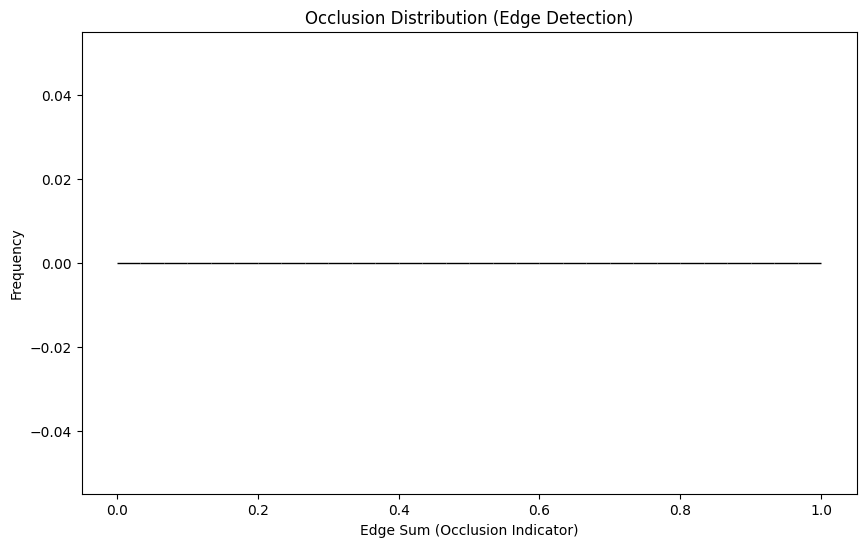

In [ ]:
# Occlusion
def detect_occlusion(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    # Apply Sobel edge detection
    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    edges = cv2.magnitude(sobel_x, sobel_y)

    edge_sum = np.sum(edges)
    return edge_sum

def plot_occlusion_variability(image_dir):
    occlusions = []
    class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]

    for cls in class_names:
        cls_folder = os.path.join(image_dir, cls)
        for img_name in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, img_name)
            occlusion_score = detect_occlusion(img_path)
            occlusions.append(occlusion_score)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(occlusions, bins=30, color="green", edgecolor="black")
    plt.title("Occlusion Distribution (Edge Detection)")
    plt.xlabel("Edge Sum (Occlusion Indicator)")
    plt.ylabel("Frequency")
    plt.show()

print("Occlusions Variability for Dataset")
plot_occlusion_variability(data_folder)

### histogram distribusi occlusion berdasarkan edge detection, tapi hasilnya kosong atau semua nilai nol. Sehingga tidak ada benda/ objek yang menghalangi gambar dalam dataset ini

### Variabilitas --> Angle

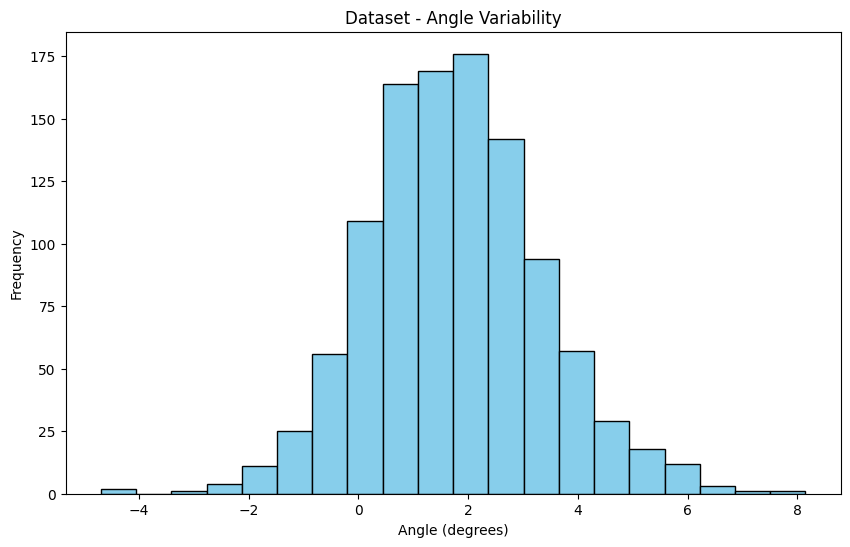

In [ ]:
# Function to calculate the dominant angle of an image
def calculate_angle(image):
    # Convert image to grayscale
    gray = np.array(image.convert('L'))

    # Apply Sobel edge detection to find edges in the image
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude and angle
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    angle = np.arctan2(sobel_y, sobel_x)

    # Return the mean angle in degrees
    return np.degrees(angle).mean()

# Function to plot angle variability for the images in the dataset
def plot_angle_variability(image_dir, dataset_name="Dataset"):
    # Get all image files in the data folder (no subfolders)
    all_images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not all_images:
        print(f"No images found in {image_dir}. Please check the data folder.")
        return

    angles = []

    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)
        try:
            img = Image.open(img_path)
            angles.append(calculate_angle(img))
        except Exception as e:
            print(f"Error opening image {img_name}: {e}")

    # Plot histogram for the angles
    plt.figure(figsize=(10, 6))
    plt.hist(angles, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"{dataset_name} - Angle Variability")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
    plt.show()

# Example usage with your dataset folder
plot_angle_variability(data_folder, "Dataset")

* Distribusinya **condong ke kanan (right-skewed)**.
* Artinya, lebih banyak gambar yang **miring ke arah positif** (misalnya kepala condong kanan atau objek miring searah jarum jam).
* Ada sebagian kecil gambar yang **miring ke kiri** (sudut negatif), tapi jumlahnya jauh lebih sedikit.


### Dimension Image and Resolutions

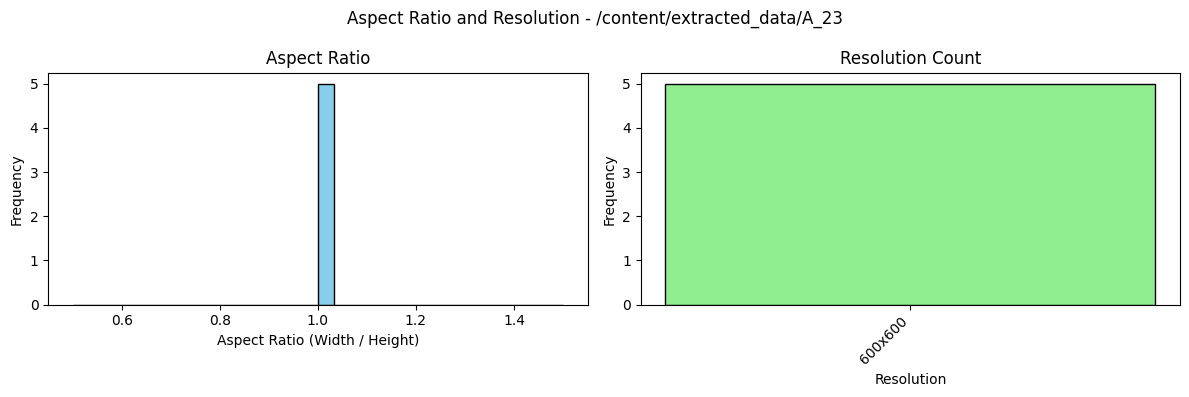

In [ ]:
def display_aspect_ratio_and_resolution_distribution(directory, n_images):
    # Get all image files in the directory
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

    if not image_files:
        print(f"No images found in {directory}. Please check the data folder.")
        return

    selected_images = random.sample(image_files, min(n_images, len(image_files)))
    aspect_ratios = []
    resolutions = []

    for img_file in selected_images:
        image_path = os.path.join(directory, img_file)
        try:
            img = Image.open(image_path)

            # Skip non-RGB images
            if len(img.getbands()) < 3:
                continue

            width, height = img.size
            aspect_ratios.append(width / height)
            resolutions.append((width, height))

        except Exception as e:
            print(f"Error reading {image_path}: {e}")


    plt.figure(figsize=(12, 4))

    # Aspect Ratio Histogram
    plt.subplot(1, 2, 1)
    plt.hist(aspect_ratios, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Aspect Ratio")
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Frequency")

    # Plot Resolution Frequency
    res_counts = Counter(resolutions)
    res_labels = [f"{w}x{h}" for (w, h) in res_counts.keys()]
    res_values = list(res_counts.values())

    plt.subplot(1, 2, 2)
    plt.bar(res_labels, res_values, color='lightgreen', edgecolor='black')
    plt.title(f"Resolution Count")
    plt.xlabel("Resolution")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')

    plt.suptitle(f"Aspect Ratio and Resolution - {directory}")
    plt.tight_layout()
    plt.show()

display_aspect_ratio_and_resolution_distribution(data_folder, 5)

* Semua gambar memiliki **aspect ratio 1.0**, artinya **width = height**.
* Ini menunjukkan bahwa semua gambar berbentuk **persegi** (square)
* Seluruh gambar beresolusi **600×600 pixel**.

### Deteksi Grayscale & RGB

In [ ]:
modes = []
image_files = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

for fname in image_files:
    file_path = os.path.join(data_folder, fname)
    try:
        with Image.open(file_path) as img:
            modes.append(img.mode)
    except Exception as e:
        print(f"Error opening image: {file_path} - {e}")

mode_counts = pd.Series(modes).value_counts()

print("Image Color Mode Distribution:")
print(mode_counts)

Image Color Mode Distribution:
RGB    1074
Name: count, dtype: int64


### Seluruh gambar adalah **RGB**, tidak ada terdeteksi grayscale

### Normalisasi dan Resize

In [ ]:
import os
import numpy as np
from PIL import Image

# Normalisasi dan Resize
def load_and_normalize_image(img_path, img_size=(100, 100)):
    img = Image.open(img_path).convert('RGB')  # Convert to RGB
    img = img.resize(img_size)  # Resize
    img_array = np.array(img) / 255.0  # Normalisasi
    return img_array

image_paths = [os.path.join(data_folder, fname)
               for fname in os.listdir(data_folder)
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

images = np.array([load_and_normalize_image(path) for path in image_paths])
print(images.shape)

(1074, 100, 100, 3)


## Split Data

In [ ]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 10% validation, and 10% testing
X_train, X_temp = train_test_split(images, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data validasi: {len(X_val)}")
print(f"Jumlah data testing : {len(X_test)}")

Jumlah data training: 859
Jumlah data validasi: 107
Jumlah data testing : 108


## Noise
 digunakan untuk membentuk Denoising Autoencoder (DAE), sehingga digunakan untuk dilatih untuk menghilangkan noise dari input dan mengembalikannya ke bentuk aslinya.

In [ ]:
# Noise
# Noise factor -> 0,5
# Mean - > 0
# Standar Deviasi -> 0,1

def add_noise_to_images(images, noise_factor=0.5, mean=0.0, stddev=0.1):
    noisy_images = images + noise_factor * np.random.normal(loc=mean, scale=stddev, size=images.shape)
    return np.clip(noisy_images, 0.0, 1.0)

# Fungsi np.clip() digunakan untuk memastikan nilai piksel tetap dalam rentang 0 hingga 1.

x_train_noisy = add_noise_to_images(X_train)
x_val_noisy   = add_noise_to_images(X_val)
x_test_noisy  = add_noise_to_images(X_test)

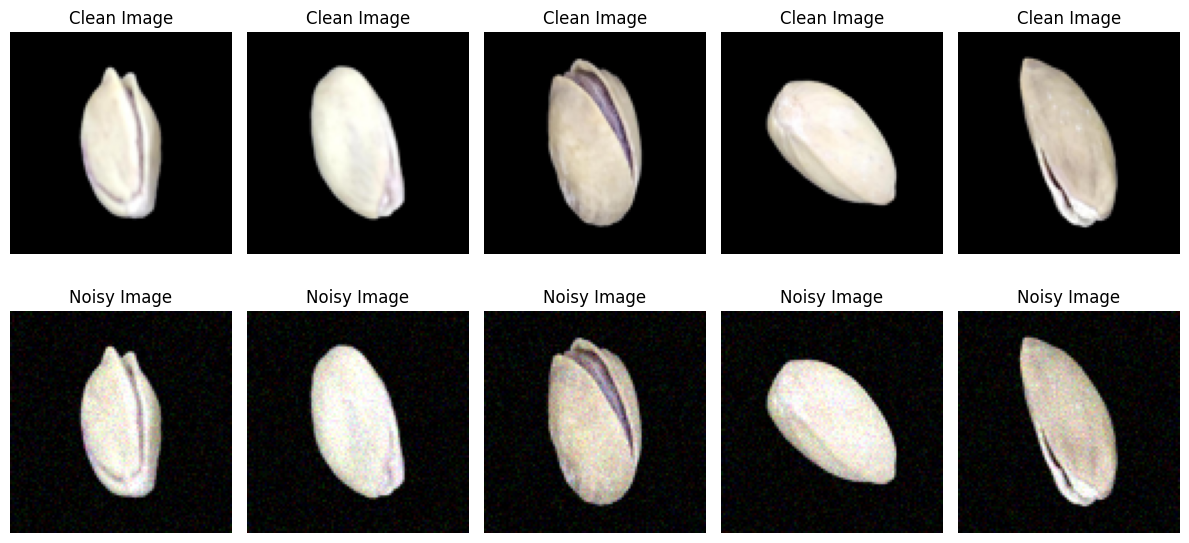

In [ ]:
def plot_noisy_and_clean_images(clean_images, noisy_images, n_samples=5):
    plt.figure(figsize=(12, 6))

    for i in range(n_samples):
        # Plot clean image
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(clean_images[i])
        plt.title("Clean Image")
        plt.axis('off')

        # Plot noisy image
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(noisy_images[i])
        plt.title("Noisy Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_noisy_and_clean_images(X_train, x_train_noisy, n_samples=5)

# Model

## Baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# SSIM metrics
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Input
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_CHANNELS = 3

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

def build_autoencoder_model(input_shape):
    IMG_CHANNELS = input_shape[2]

    # Encoder
    input_layer = Input(shape=input_shape, name='input_layer')
    # conv2d
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d')(input_layer) # 100x100x3 → 100x100x32
    # max_pooling2d
    x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d')(x) # 100x100x32 → 50x50x32
    # conv2d_1
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_1')(x) # 50x50x32 → 50x50x64
    # max_pooling2d_1
    x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d_1')(x) # 50x50x64 → 25x25x64

    # conv2d_2 (Bottleneck/Latent Space)
    encoder_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_2')(x) # 25x25x64 → 25x25x64


    # Decoder
    # up_sampling2d
    x = UpSampling2D(size=(2, 2), name='up_sampling2d')(encoder_output) # 25x25x64 → 50x50x64
    # conv2d_3
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2d_3')(x) # 50x50x64 → 50x50x32
    # up_sampling2d_1
    x = UpSampling2D(size=(2, 2), name='up_sampling2d_1')(x) # 50x50x32 → 100x100x32

    # conv2d_4 (Output Layer)
    decoder_output = Conv2D(filters=IMG_CHANNELS, kernel_size=(3, 3), activation='sigmoid', padding='same', name='conv2d_4')(x) # 100x100x32 → 100x100x3

    autoencoder = Model(inputs=input_layer, outputs=decoder_output, name='Autoencoder_Denoising')
    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=[ssim_metric])

    return autoencoder

autoencoder_model = build_autoencoder_model(input_shape)
autoencoder_model.summary()

Model: "Autoencoder_Denoising"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Compile
autoencoder_model = build_autoencoder_model(input_shape)

autoencoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[ssim_metric])

# Fit model
history = autoencoder_model.fit(
    x_train_noisy, X_train,           # Training data (noisy images and clean images), model belajar mencocokan noisy ke gambar asli
    epochs=50,
    batch_size=16,
    validation_data=(x_val_noisy, X_val),  # Validation data (noisy and clean validation data)
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.1028 - ssim_metric: 0.3870 - val_loss: 0.0034 - val_ssim_metric: 0.8855
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - ssim_metric: 0.8906 - val_loss: 0.0026 - val_ssim_metric: 0.9009
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - ssim_metric: 0.9032 - val_loss: 0.0020 - val_ssim_metric: 0.9154
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - ssim_metric: 0.9181 - val_loss: 0.0020 - val_ssim_metric: 0.9233
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - ssim_metric: 0.9238 - val_loss: 0.0014 - val_ssim_metric: 0.9276
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - ssim_metric: 0.9295 - val_loss: 0.0013 - val_ssim_metric: 0.9313
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - ssim_metric: 0.9338 - val_loss: 0.0012 - val_ssim_metric: 0.9351
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - s

In [ ]:
print("\nEvaluating model on the test set...")
results = autoencoder_model.evaluate(x_test_noisy, X_test, batch_size=16, verbose=1)
test_loss = results[0]
test_ssim = results[1]
print(f"Final Test Loss (MSE): {test_loss:.6f}")
print(f"Final Test SSIM:       {test_ssim:.6f}")


Evaluating model on the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.9756e-04 - ssim_metric: 0.9660
Final Test Loss (MSE): 0.000395
Final Test SSIM:       0.966069


##  Hasil Evaluasi Model:

| Metrik         | Nilai      | Interpretasi                                                                |
| -------------- | ---------- | --------------------------------------------------------------------------- |
| **Loss (MSE)** | `0.000395` | Kesalahan rata-rata piksel sangat kecil → hasil rekonstruksi sangat presisi |
| **SSIM**       | `0.9661`   | Sangat tinggi → struktur dan visual mirip dengan gambar asli                |

- tidak ada overfitting, dan model mampu memproses data baru dengan baik.

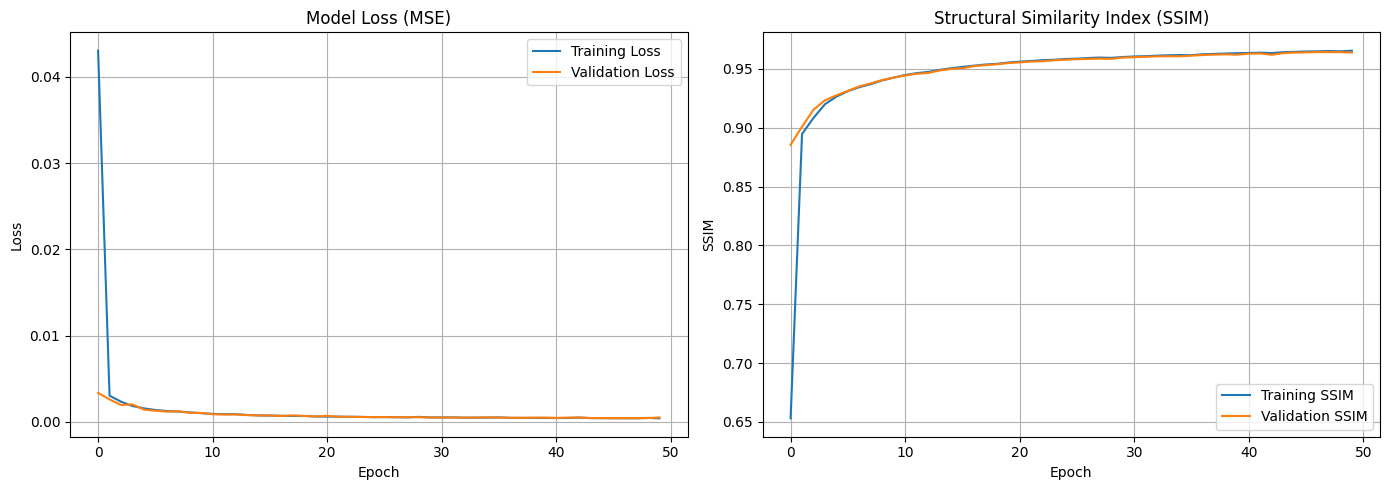

In [ ]:
# Plotting Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting SSIM
plt.subplot(1, 2, 2)
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Validation SSIM')
plt.title('Structural Similarity Index (SSIM)')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##  Model Loss (MSE)

* **MSE (Mean Squared Error)** mengukur seberapa besar perbedaan piksel antara gambar asli dan hasil rekonstruksi.
* **Training Loss** dan **Validation Loss** turun sangat cepat sejak awal (epoch 0–5), kemudian stabil di bawah **0.01**. Sehingga model belajar sangat cepat pada beberapa epoch pertama.
* **Tidak overfitting**: garis training dan validation hampir sejajar, artinya performa di data training ≈ data validasi.
* **Nilai loss sangat kecil**: menunjukkan hasil rekonstruksi yang akurat secara piksel.

## Structural Similarity Index (SSIM)

* SSIM mengukur **kemiripan struktur visual** antara dua gambar (bernilai antara 0 dan 1).
* Nilai mendekati **1 berarti gambar hasil rekonstruksi sangat mirip dengan aslinya**.

### Interpretasi:

* **SSIM meningkat tajam** di awal, dari sekitar 0.65 ke atas 0.95 dalam < 10 epoch.
* Setelah itu, **stabil di atas 0.96**, baik untuk training maupun validation.
* **Performa sangat baik**, menunjukkan bahwa hasil output model bukan hanya sama secara piksel (MSE), tapi juga **preservasi struktur visual** tetap terjaga.

# Modifikasi

In [ ]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_CHANNELS = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

def build_autoencoder_model1(input_shape):
    IMG_CHANNELS = input_shape[2]

    # Encoder
    input_layer = Input(shape=input_shape, name='input_layer')

    # Initial Conv Block
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', name='conv2d_initial')(input_layer)
    x = BatchNormalization(name='bn_initial')(x)
    x = Activation('relu', name='relu_initial')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d_0')(x) # 100x100x32 -> 50x50x32

    # Encoder Block 1
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv2d_enc1')(x)
    x = BatchNormalization(name='bn_enc1')(x)
    x = Activation('relu', name='relu_enc1')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d_1')(x) # 50x50x64 -> 25x25x64


    # Bottleneck
    encoder_output = Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='conv2d_bottleneck')(x)
    encoder_output = BatchNormalization(name='bn_bottleneck')(encoder_output)
    encoder_output = Activation('relu', name='relu_bottleneck')(encoder_output) # 25x25x128

    # Decoder
    # Decoder Block 1
    x = UpSampling2D(size=(2, 2), name='up_sampling2d_0')(encoder_output) # 25x25x128 -> 50x50x128
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv2d_dec1')(x)
    x = BatchNormalization(name='bn_dec1')(x)
    x = Activation('relu', name='relu_dec1')(x)

    # Decoder Block 2
    x = UpSampling2D(size=(2, 2), name='up_sampling2d_1')(x) # 50x50x64 -> 100x100x64
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', name='conv2d_dec2')(x)
    x = BatchNormalization(name='bn_dec2')(x)
    x = Activation('relu', name='relu_dec2')(x)

    # Output Layer
    decoder_output = Conv2D(filters=IMG_CHANNELS, kernel_size=(3, 3), activation='sigmoid', padding='same', name='output_layer')(x)

    autoencoder = Model(inputs=input_layer, outputs=decoder_output, name='Autoencoder_Denoising')
    optimizer = Adam(learning_rate=0.0001)

    autoencoder = Model(inputs=input_layer, outputs=decoder_output, name='Autoencoder_Denoising')
    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=[ssim_metric])
    return autoencoder

autoencoder_model1 = build_autoencoder_model1(input_shape)
autoencoder_model1.summary()

Model: "Autoencoder_Denoising"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_initial (Conv2D)         │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_initial (BatchNormalization) │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_initial (Activation)       │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_0 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_enc1 (Conv2D)            │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_enc1 (BatchNormalization)    │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_enc1 (Activation)          │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_bottleneck (Conv2D)      │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_bottleneck                   │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_bottleneck (Activation)    │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_0 (UpSampling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dec1 (Conv2D)            │ (None, 50, 50, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dec1 (BatchNormalization)    │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dec1 (Activation)          │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dec2 (Conv2D)            │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dec2 (BatchNormalization)    │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dec2 (Activation)          │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv2D)           │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,651 (733.01 KB)

 Trainable params: 187,011 (730.51 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_ssim_metric',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\nMemulai pelatihan model...")
history1 = autoencoder_model1.fit(
    x_train_noisy,
    X_train,
    epochs=100,
    batch_size=8,
    shuffle=True,
    validation_data=(x_val_noisy, X_val),
    callbacks=[early_stopping],
    verbose=1
)


Memulai pelatihan model...
Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.0322 - ssim_metric: 0.2682 - val_loss: 0.0471 - val_ssim_metric: 0.2506
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0013 - ssim_metric: 0.5004 - val_loss: 0.0285 - val_ssim_metric: 0.5807
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.2270e-04 - ssim_metric: 0.6302 - val_loss: 0.0064 - val_ssim_metric: 0.7229
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.8416e-04 - ssim_metric: 0.7136 - val_loss: 0.0024 - val_ssim_metric: 0.7271
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.7883e-04 - ssim_metric: 0.7672 - val_loss: 0.0018 - val_ssim_metric: 0.7592
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.1424e-04 - ssim_metric: 0.8127 - val_loss: 0.0013 - val_ssim_metric: 0.7980
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.4330e-04 - ssim_metric: 0.8399 - val_loss: 9.6925e-04 - val_ssim_metric: 0

In [ ]:
print("\nEvaluating model on the test set...")
results = autoencoder_model1.evaluate(x_test_noisy, X_test, batch_size=16, verbose=1)
test_loss = results[0]
test_ssim = results[1]
print(f"Final Test Loss (MSE): {test_loss:.6f}")
print(f"Final Test SSIM:       {test_ssim:.6f}")


Evaluating model on the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 1.7315e-04 - ssim_metric: 0.9807
Final Test Loss (MSE): 0.000173
Final Test SSIM:       0.980844


##  Hasil Evaluasi Model:

| Metrik         | Nilai      | Interpretasi                                                                |
| -------------- | ---------- | --------------------------------------------------------------------------- |
| **Loss (MSE)** | `0.000173` | Kesalahan rata-rata piksel sangat kecil → hasil rekonstruksi sangat presisi |
| **SSIM**       | `0.9808`   | Sangat tinggi → struktur dan visual mirip dengan gambar asli                |

- tidak ada overfitting, dan model mampu memproses data baru dengan baik.

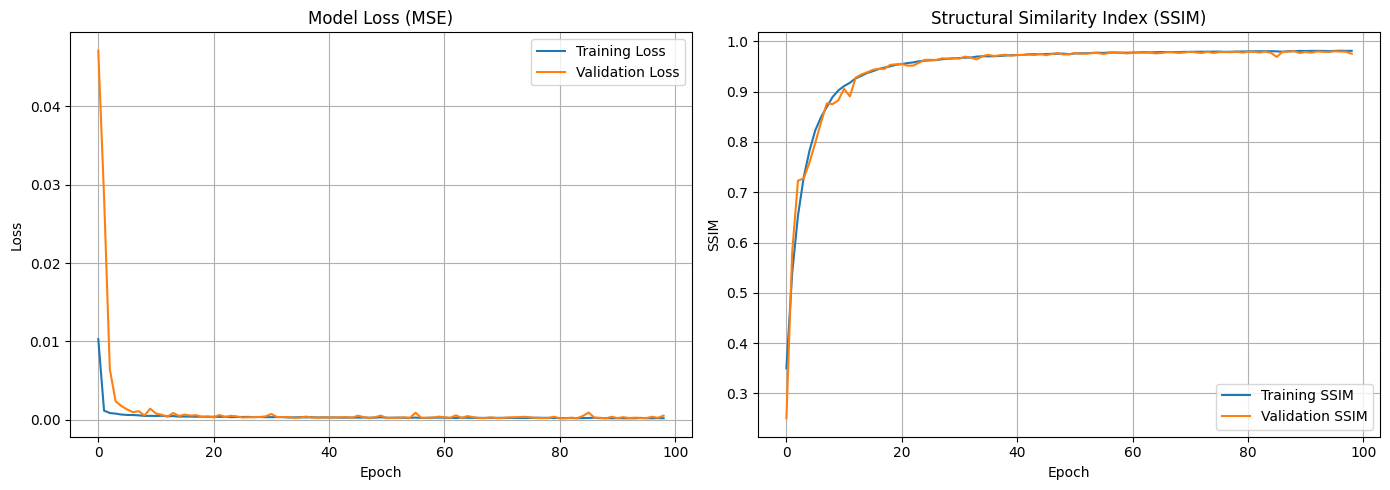

In [ ]:
# Plotting Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting SSIM
plt.subplot(1, 2, 2)
plt.plot(history1.history['ssim_metric'], label='Training SSIM')
plt.plot(history1.history['val_ssim_metric'], label='Validation SSIM')
plt.title('Structural Similarity Index (SSIM)')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##  Model Loss (MSE)

* **MSE (Mean Squared Error)** mengukur seberapa besar perbedaan piksel antara gambar asli dan hasil rekonstruksi.
* **Training Loss** dan **Validation Loss** turun sangat cepat sejak awal (epoch 0–5), kemudian stabil di bawah **0.01**. Sehingga model belajar sangat cepat pada beberapa epoch pertama.
* **Tidak overfitting**: garis training dan validation hampir sejajar, artinya performa di data training ≈ data validasi.
* **Nilai loss sangat kecil**: menunjukkan hasil rekonstruksi yang akurat secara piksel.

## Structural Similarity Index (SSIM)

* SSIM mengukur **kemiripan struktur visual** antara dua gambar (bernilai antara 0 dan 1).
* Nilai mendekati **1 berarti gambar hasil rekonstruksi sangat mirip dengan aslinya**.

### Interpretasi:

* **SSIM meningkat tajam** di awal, dari sekitar 0.75 ke atas 0.95 dalam < 10 epoch.
* Setelah itu, **stabil di atas 0.98**, baik untuk training maupun validation.
* **Performa sangat baik**, menunjukkan bahwa hasil output model bukan hanya sama secara piksel (MSE), tapi juga **preservasi struktur visual** tetap terjaga.

# **Evaluasi**

1. **MSE (Mean Squared Error)**:

   * Pada **Model Modifikasi**, **MSE** lebih rendah (0.000173) dibandingkan dengan **Baseline** (0.000395). MSE yang lebih rendah menunjukkan bahwa model modifikasi memiliki kesalahan yang lebih kecil antara gambar yang diprediksi dan gambar asli.

2. **SSIM (Structural Similarity Index)**:

   * Pada **Model Modifikasi**, **SSIM** adalah 0.980844, yang lebih tinggi dibandingkan dengan **Baseline** yang memiliki SSIM sebesar 0.966069. SSIM yang lebih tinggi menunjukkan bahwa model modifikasi menghasilkan gambar yang lebih mirip dengan gambar asli (struktur yang lebih mirip)

### **Kesimpulan**:

* **Model modifikasi** lebih unggul dari segi **MSE** dan **SSIM**, yang menunjukkan bahwa model tersebut menghasilkan rekonstruksi gambar yang lebih akurat dan lebih mirip dengan gambar asli dibandingkan dengan model baseline.